# Input Processing

In [67]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import posixpath
import wfdb
from wfdb import processing
from PIL import Image
import pywt

## Settings 

In [111]:
dataset_name = 'afdb'

def read_records(data_path, sample_size_seconds=30, samples_per_second=250, batch_size=100):
    samples = []
    labels = []
    # Sample configuration
    sample_size = sample_size_seconds * samples_per_second
    
    for record_name in wfdb.get_record_list(dataset_name):
        header = wfdb.rdheader(data_path + record_name)

        if header.sig_len == 0:
            continue

        offset = 0
        samples_count = 0
        while True:
            max_sampto = header.sig_len
            sampto = min(max_sampto, offset + sample_size)
            record = wfdb.rdrecord(data_path + record_name, sampfrom=offset, sampto=sampto)
            ann = wfdb.rdann(data_path + record_name, 'atr', sampfrom=offset, sampto=sampto)
            # print('[Record {}] sample_offset={}, aux_label={}'.format(record_name, offset, ann.aux_note))
            samples.append(record)
            labels.append(ann.aux_note)
            offset = sampto
            samples_count += 1
            if sampto >= max_sampto or (batch_size is not None and samples_count == batch_size):
                break

    return samples, labels


samples, labels = read_records('../data/files/', batch_size=None)
print(len(samples), len(labels))

28126 28126


In [112]:
# dict_labels = {'[\'(N\']': 0, 
#                '[\'(AFIB\']': 1,
#                '[\'(AFIB\', \'(N\']': 0,
#                '[]': 0,
#                '[\'(AFL\']': 0}
labels_formatted = np.array([1 if '(AFIB' in key else 0 for key in labels])
print(labels_formatted)

tp = labels_formatted.sum()
total = len(labels_formatted)
print('Positive cases: {}'.format(tp))
print('Total cases: {}'.format(total))
print('Positive weight: {}%'.format(100 * tp / total))

[0 0 0 ... 0 0 0]
Positive cases: 290
Total cases: 28126
Positive weight: 1.0310744506861977%


## Label mapping

In [69]:
wfdb.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

## WFDB record:

[(104, '+')]

{'record_name': '05261',
 'n_sig': 2,
 'fs': 250,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 7500,
 'base_time': datetime.time(12, 0),
 'base_date': None,
 'comments': [],
 'sig_name': ['ECG1', 'ECG2'],
 'p_signal': array([[-0.635, -0.185],
        [-0.54 , -0.03 ],
        [-0.395, -0.055],
        ...,
        [ 0.05 , -0.04 ],
        [ 0.1  ,  0.015],
        [-0.04 ,  0.045]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['05261.dat', '05261.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [0, 0],
 'units': ['mV', 'mV'],
 'adc_res': [12, 12],
 'adc_zero': [0, 0],
 'init_value': [-127, -37],
 'checksum': [2884, 10910],
 'block_size': [0, 0]}

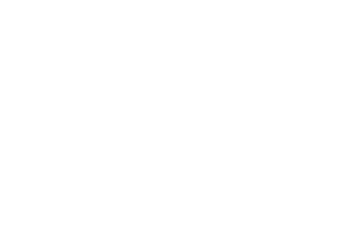

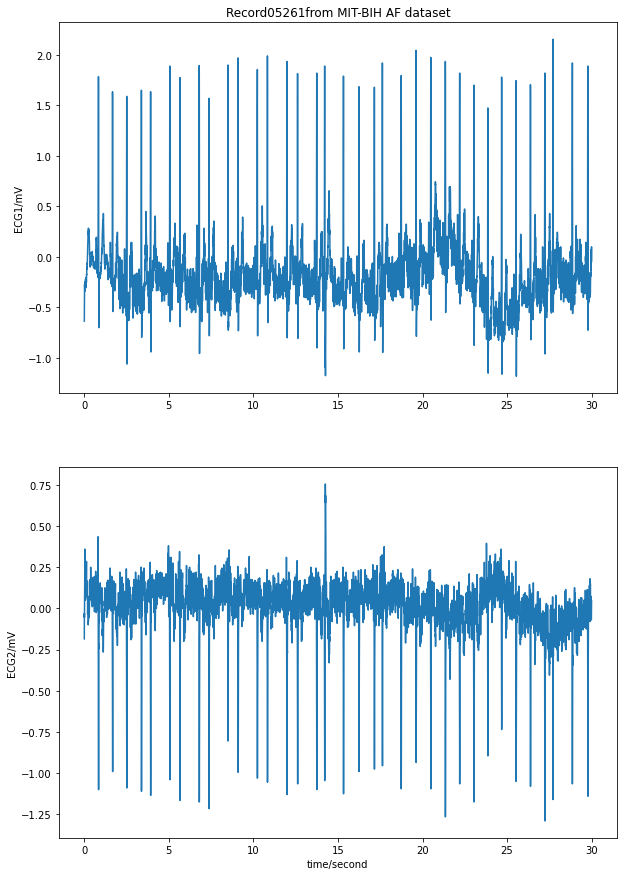

In [74]:
record = wfdb.rdrecord(data_path + record_name, sampto=sampto)
ann = wfdb.rdann(data_path + record_name, 'atr', sampto=sampto)

# Show pairs of (location, label), where location is the number of sample relative to the start
display(list(zip(ann.sample, ann.symbol)))
display(ann.aux_note)
plt.axis('off')
fig = wfdb.plot_wfdb(record=record, title='Record' + record_name + 'from MIT-BIH AF dataset',
               annotation=None,
               plot_sym=True,
               time_units='seconds',
               return_fig=True,
               figsize=(10,15))

In [45]:
def fig2rgb_array(fig):
    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    return np.fromstring(buf, dtype=np.uint8).reshape(nrows, ncols, 3)

data = fig2rgb_array(fig)
# img = Image.fromarray(data, 'RGB')
# img.save('test.png')
# img.show()

# fig.savefig('out.png', bbox_inches='tight', pad_inches=0)

/Users/miki/opt/miniconda3/envs/cs236781-project/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """


In [47]:
display(record.__dict__)

{'record_name': '04936',
 'n_sig': 2,
 'fs': 250,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 7500,
 'base_time': None,
 'base_date': None,
 'comments': [],
 'sig_name': ['ECG1', 'ECG2'],
 'p_signal': array([[-0.015, -0.32 ],
        [-0.045, -0.35 ],
        [-0.03 , -0.345],
        ...,
        [ 0.07 , -0.29 ],
        [ 0.075, -0.3  ],
        [ 0.09 , -0.285]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['04936.dat', '04936.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [0, 0],
 'units': ['mV', 'mV'],
 'adc_res': [12, 12],
 'adc_zero': [0, 0],
 'init_value': [-3, -64],
 'checksum': [63035, 14114],
 'block_size': [0, 0]}

In [ ]:
original = 
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

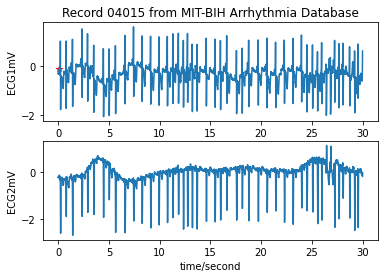

In [38]:
# Read a WFDB record and annotation. Plot all channels, and the annotation on top of channel 0.
record = wfdb.rdrecord(data_path + record_name, sampto = sampto)
annotation = wfdb.rdann(data_path + record_name, 'atr', sampto = sampto)

wfdb.plot_wfdb(record=record, annotation=annotation,
               title='Record '+ record_name  +' from MIT-BIH Arrhythmia Database',
               time_units='seconds')

## ECG Processing

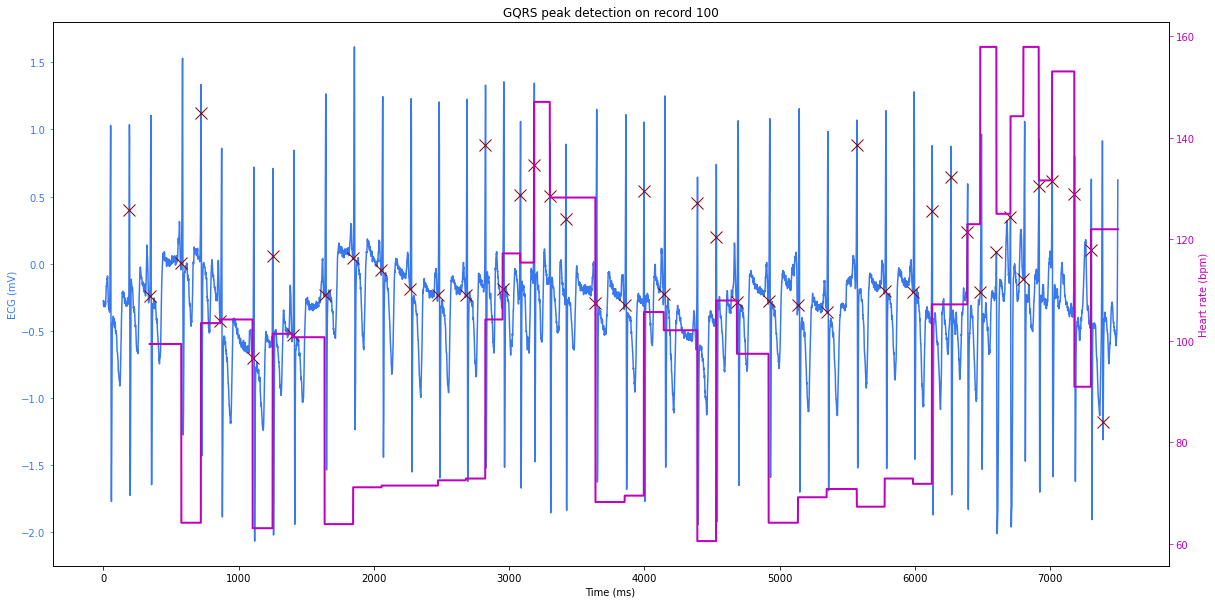

Corrected GQRS detected peak indices: [193, 352, 586, 723, 875, 1113, 1253, 1410, 1645, 1856, 2066, 2276, 2483, 2689, 2825, 2961, 3084, 3186, 3302, 3420, 3647, 3863, 3997, 4152, 4392, 4531, 4693, 4926, 5144, 5356, 5571, 5785, 5994, 6127, 6266, 6389, 6491, 6601, 6680, 6810, 6917, 7014, 7179, 7303, 7385]


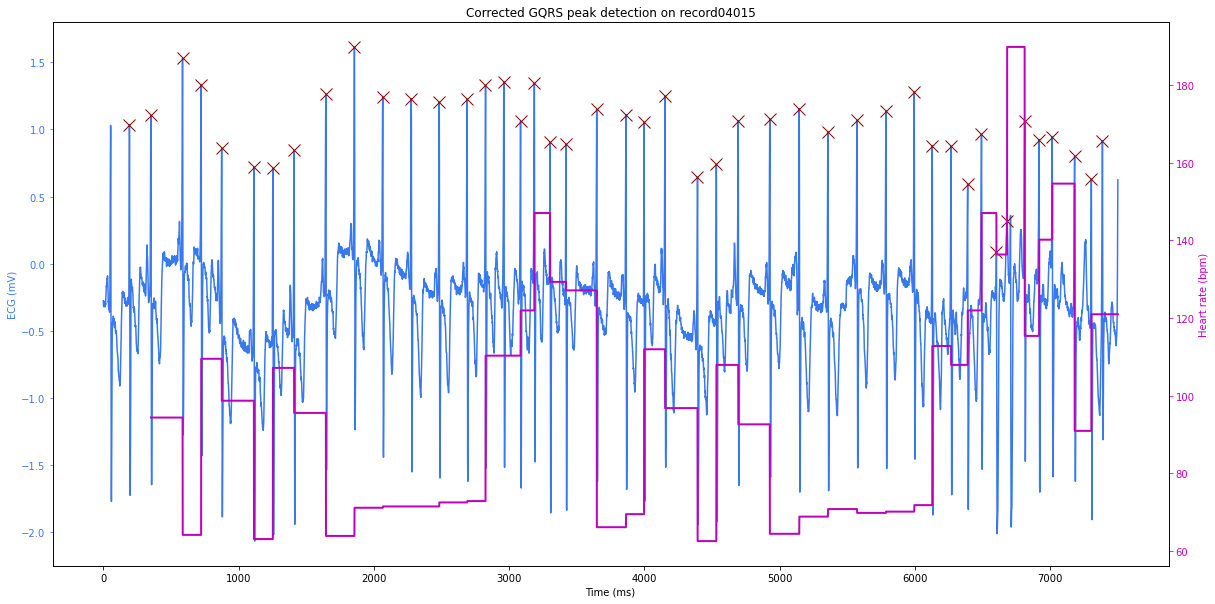

In [6]:
# Use the GQRS detection algorithm and correct the peaks

def peaks_hr(sig, peak_inds, fs, title, figsize=(20, 10), saveto=None):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', 
                 color='#8b0000', label='Peak', markersize=12)
    ax_right.plot(np.arange(N), hrs, label='Heart rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    ax_right.set_ylabel('Heart rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()

# Load the WFDB record and the physical samples
record = wfdb.rdrecord(data_path + record_name, sampfrom=0, sampto=sampto, channels=[0])

# Use the GQRS algorithm to detect QRS locations in the first channel
qrs_inds = processing.qrs.gqrs_detect(sig=record.p_signal[:,0], fs=record.fs)

# Plot results
peaks_hr(sig=record.p_signal, peak_inds=qrs_inds, fs=record.fs,
         title="GQRS peak detection on record 100")
    
# Correct the peaks shifting them to local maxima
min_bpm = 20
max_bpm = 230
#min_gap = record.fs * 60 / min_bpm
# Use the maximum possible bpm as the search radius
search_radius = int(record.fs * 60 / max_bpm)
corrected_peak_inds = processing.peaks.correct_peaks(record.p_signal[:,0], 
                                                     peak_inds=qrs_inds,
                                                     search_radius=search_radius, 
                                                     smooth_window_size=150)

# Display results
print('Corrected GQRS detected peak indices:', sorted(corrected_peak_inds))
peaks_hr(sig=record.p_signal, peak_inds=sorted(corrected_peak_inds), fs=record.fs,
         title="Corrected GQRS peak detection on record" + record_name)
    

In [7]:
# Use the XQRS detection algorithm and compare results to reference annotations
import wfdb
from wfdb import processing
sig, fields = wfdb.rdsamp(data_path + record_name, channels=[0], sampto=sampto)
ann_ref = wfdb.rdann(data_path + record_name, 'atr', sampto=sampto)

# Run QRS detection on signal
xqrs = processing.XQRS(sig=sig[:,0], fs=fields['fs'])
xqrs.detect()
# Alternatively, use the gateway function to get the QRS indices directly
# qrs_inds = processing.xqrs_detect(sig=sig[:,0], fs=fields['fs'])

# Compare detected QRS complexes to reference annotation.
# Note, first sample in 100.atr is not a QRS.
comparitor = processing.compare_annotations(ref_sample=ann_ref.sample[1:],
                                            test_sample=xqrs.qrs_inds,
                                            window_width=int(0.1 * fields['fs']),
                                            signal=sig[:,0])

# Print and plot the results
comparitor.print_summary()
comparitor.plot(title='xqrs detected QRS vs reference annotations')

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


ValueError: min() arg is an empty sequence